In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzbuilder_analysis.rendering as rg
import gzbuilder_analysis.fitting as fg
import gzbuilder_analysis.parsing as pg
import gzbuilder_analysis.config as cfg
try:
    from gzbuilder_analysis.rendering.cuda import calculate_model, oversampled_sersic_component
except ModuleNotFoundError:
    from gzbuilder_analysis.rendering import calculate_model, oversampled_sersic_component
from gzbuilder_analysis.fitting import Model, fit_model
from PIL import Image
import argparse
from asinh_cmap import asinh_cmap

In [3]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')
models = pd.read_pickle('lib/models.pickle')

In [4]:
subject_id = 21096801

In [5]:
fm = fitting_metadata.loc[subject_id]
data = fm['galaxy_data']
sigma_image = fm['sigma_image']
psf = fm['psf']

In [6]:
model = models.loc[subject_id]['best_individual']
tuned_model = models.loc[subject_id]['tuned_best_individual']
agg_model = models.loc[subject_id]['aggregate']
tuned_agg_model = models.loc[subject_id]['tuned_aggregate']

In [7]:
extent = (np.array([[-1, -1],[1, 1]]) * data.shape).T.ravel() / 2 * 0.396
imshow_kwargs = {
    'cmap': asinh_cmap, 'origin': 'lower',
    'extent': extent
}

In [8]:
m = Model(
    model,
    data,
    psf=psf,
    sigma_image=sigma_image
)
m_tuned = Model(
    tuned_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)

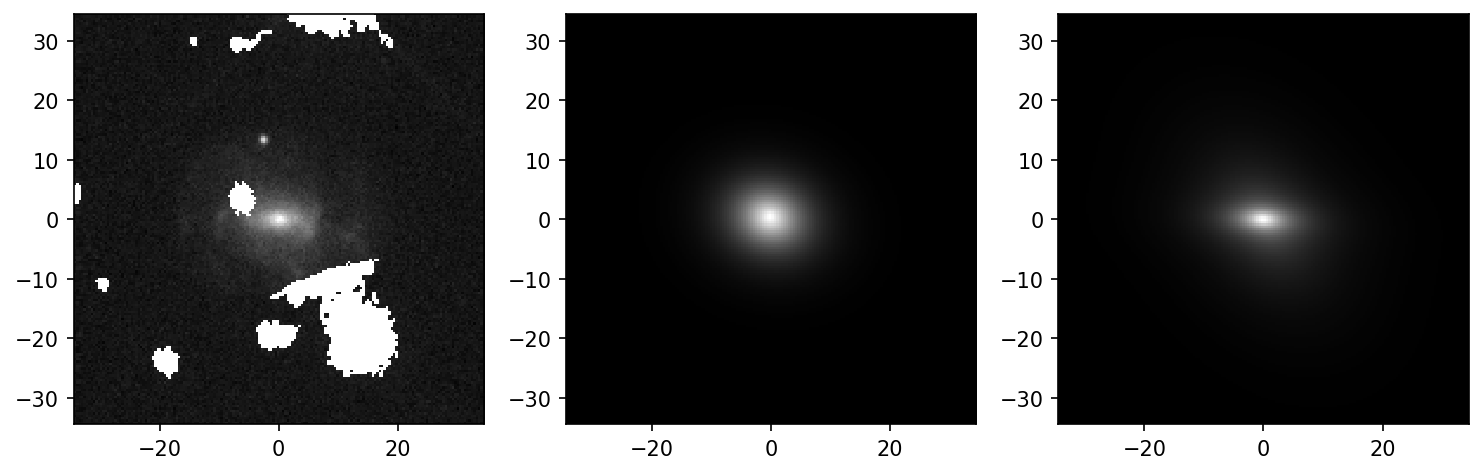

In [9]:
plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(131)
plt.imshow(data, **imshow_kwargs)
plt.subplot(132)
plt.imshow(m.render(), **imshow_kwargs)
plt.subplot(133)
plt.imshow(m_tuned.render(), **imshow_kwargs)

In [10]:
m_agg = Model(
    agg_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)
m_agg_tuned = Model(
    tuned_agg_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)

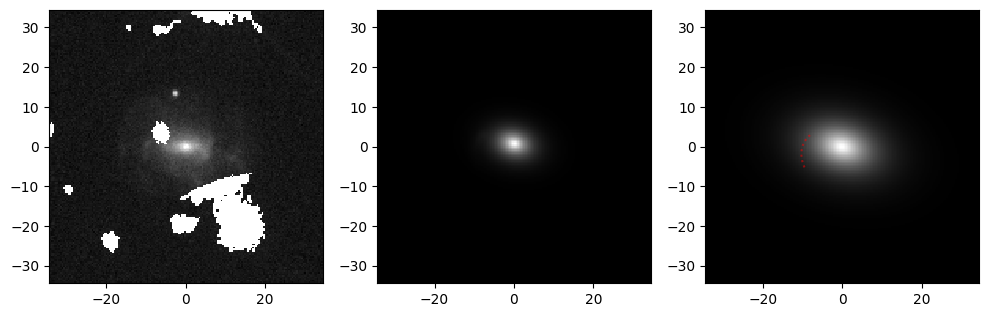

In [11]:
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(131)
plt.imshow(data, **imshow_kwargs)
plt.subplot(132)
plt.imshow(m_agg.render(), **imshow_kwargs)
plt.subplot(133)
plt.imshow(m_agg_tuned.render(), **imshow_kwargs)
for points, params in tuned_agg_model['spiral']:
    plt.plot(*(points - np.array(data.shape) / 2).T*0.396, 'r:', alpha=0.5)

What do the parameters look like?

In [12]:
pd.concat(
    (
        m.params.rename('raw BI').dropna(), m_tuned.params.rename('tuned BI').dropna(),
        m_agg.params.rename('Agg').dropna(), m_agg_tuned.params.rename('tuned Agg').dropna()
    ),
    axis=1
).T

component     bulge                                                            \
parameter         I         Re    c        mux        muy         n         q   
raw BI     0.250000   0.963860  2.0  86.143312  88.019531  0.990000  0.193816   
tuned BI   0.098263  17.597169  2.0  86.174348  86.281379  1.631782  0.363496   
Agg        0.200000   1.872745  2.0  86.993683  88.023302  1.000000  0.498994   
tuned Agg  0.000000   0.000000  2.0  86.993683  88.023302  1.000000  0.498994   

component                disk                                             \
parameter      roll         I         Re    c        mux        muy    n   
raw BI     1.951303  0.125000  16.570732  2.0  85.803469  87.000000  1.0   
tuned BI   1.532216  0.047018  34.117453  2.0  87.386539  85.219742  1.0   
Agg        1.478271  0.200000  11.763361  2.0  86.519523  88.141250  1.0   
tuned Agg  1.478271  0.129630  22.157753  2.0  86.324184  86.132374  1.0   

component                       spiral0                   
parameter         q      roll         I   falloff spread  
raw BI     0.835134  1.275588       NaN       NaN    NaN  
tuned BI   0.703167  0.604795       NaN       NaN    NaN  
Agg        0.725880  1.321709  0.100000  1.000000    0.5  
tuned Agg  0.664359  1.308671  3.596333  1.869173    0.0